In [57]:
import os
import sys
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill
import seaborn as sns
import zipfile

plt.style.use("default")

In [60]:
SESSION_FILE = "session.dill"

In [ ]:
if os.path.exists(SESSION_FILE):
    with open(SESSION_FILE, "rb") as f:
        session = dill.load(f)

In [39]:
class Dataset:
    def __init__(self, name="Leukemia_GSE28497.csv",
                 url="https://sbcb.inf.ufrgs.br/data/cumida/Genes/Leukemia/GSE28497/"):
        self.filepath = name
        if not os.path.exists(self.filepath):
            print(f"Downloading dataset {name}...", file=sys.stderr)
            urllib.request.urlretrieve(url + name, filename=name)
        self.load_dataset()

    def load_dataset(self):
        # Load the dataset
        self.data = pd.read_csv(self.filepath)
        print(self.data.head())
        self.data.set_index(self.data.columns[0], inplace=True) #As it is a human identifier, can use it as ind
        self.data['type'], self.label_mapping = pd.factorize(self.data['type'])

    def get_label_mapping(self):
        return self.label_mapping


In [40]:
dataset = Dataset()

            samples        type  1007_s_at   1053_at    117_at    121_at  \
0  GSM705467.CEL.gz  B-CELL_ALL   7.409521  5.009216  4.173607  7.315369   
1  GSM705468.CEL.gz  B-CELL_ALL   7.177109  5.415108  4.426778  7.550818   
2  GSM705469.CEL.gz  B-CELL_ALL   6.564918  5.248020  4.252414  7.175169   
3  GSM705470.CEL.gz  B-CELL_ALL   6.872028  5.155963  4.388849  7.365933   
4  GSM705471.CEL.gz  B-CELL_ALL   7.402105  5.509826  4.284291  7.214947   

   1255_g_at   1294_at   1316_at   1320_at  ...  AFFX-r2-Hs28SrRNA-5_at  \
0   3.185411  7.620644  3.731541  3.471587  ...                2.968822   
1   3.134181  7.685723  3.907953  3.650995  ...                2.982888   
2   3.017718  7.956261  3.354557  3.302989  ...                2.897425   
3   3.031735  7.830002  3.508926  3.412491  ...                3.024722   
4   2.925269  7.789838  3.610425  3.362593  ...                3.259802   

   AFFX-r2-Hs28SrRNA-M_at  AFFX-r2-P1-cre-3_at  AFFX-r2-P1-cre-5_at  \
0                3.22

In [41]:
print(dataset.data.columns)

Index(['type', '1007_s_at', '1053_at', '117_at', '121_at', '1255_g_at',
       '1294_at', '1316_at', '1320_at', '1405_i_at',
       ...
       'AFFX-r2-Hs28SrRNA-5_at', 'AFFX-r2-Hs28SrRNA-M_at',
       'AFFX-r2-P1-cre-3_at', 'AFFX-r2-P1-cre-5_at', 'AFFX-ThrX-3_at',
       'AFFX-ThrX-5_at', 'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at',
       'AFFX-TrpnX-5_at', 'AFFX-TrpnX-M_at'],
      dtype='object', length=22284)


In [42]:
print(dataset.data.head())

                  type  1007_s_at   1053_at    117_at    121_at  1255_g_at  \
samples                                                                      
GSM705467.CEL.gz     0   7.409521  5.009216  4.173607  7.315369   3.185411   
GSM705468.CEL.gz     0   7.177109  5.415108  4.426778  7.550818   3.134181   
GSM705469.CEL.gz     0   6.564918  5.248020  4.252414  7.175169   3.017718   
GSM705470.CEL.gz     0   6.872028  5.155963  4.388849  7.365933   3.031735   
GSM705471.CEL.gz     0   7.402105  5.509826  4.284291  7.214947   2.925269   

                   1294_at   1316_at   1320_at  1405_i_at  ...  \
samples                                                    ...   
GSM705467.CEL.gz  7.620644  3.731541  3.471587   4.167374  ...   
GSM705468.CEL.gz  7.685723  3.907953  3.650995   3.860015  ...   
GSM705469.CEL.gz  7.956261  3.354557  3.302989   3.335324  ...   
GSM705470.CEL.gz  7.830002  3.508926  3.412491   3.439769  ...   
GSM705471.CEL.gz  7.789838  3.610425  3.362593   3.412095

In [43]:
print(dataset.get_label_mapping())
# ? What do these classes represent?

Index(['B-CELL_ALL', 'B-CELL_ALL_TCF3-PBX1', 'B-CELL_ALL_HYPERDIP',
       'B-CELL_ALL_HYPO', 'B-CELL_ALL_MLL', 'B-CELL_ALL_T-ALL',
       'B-CELL_ALL_ETV6-RUNX1'],
      dtype='object')


## Class imbalance

In [44]:
for cls, cnt in zip(dataset.get_label_mapping(), dataset.data["type"].value_counts()):
    print(f"{cls}: {cnt}")

B-CELL_ALL: 74
B-CELL_ALL_TCF3-PBX1: 53
B-CELL_ALL_HYPERDIP: 51
B-CELL_ALL_HYPO: 46
B-CELL_ALL_MLL: 22
B-CELL_ALL_T-ALL: 18
B-CELL_ALL_ETV6-RUNX1: 17


In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X = dataset.data.drop('type', axis=1)  # features
y = dataset.data['type']  # target

In [47]:
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)

## Models

In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.base

In [49]:
import numpy as np
import seaborn as sns


def train_and_evaluate_model(
    model: sklearn.base.BaseEstimator,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
) -> tuple[np.ndarray, str, np.ndarray, str]:
    # Train the model using cross-validation
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)

    # Evaluate the model on training data
    train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
    train_classification_report = classification_report(
        y_train,
        y_train_pred,
        zero_division=1,
        target_names=dataset.get_label_mapping(),
    )

    # Evaluate the model on validation data
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    test_classification_report = classification_report(
        y_test,
        y_test_pred,
        zero_division=1,
        target_names=dataset.get_label_mapping(),
    )

    return (
        train_confusion_matrix,
        train_classification_report,
        test_confusion_matrix,
        test_classification_report,
    )


def plot_confusion_matrix_and_report(
    train_confusion_matrix: np.ndarray,
    train_classification_report: str,
    test_confusion_matrix: np.ndarray,
    test_classification_report: str,
    estimator_name: str,
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot confusion matrix for train data
    sns.heatmap(
        train_confusion_matrix, annot=True, fmt="d", ax=axs[0]
    )
    axs[0].set_title(f"Train Confusion Matrix ({estimator_name})")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")

    # Plot confusion matrix for test data
    sns.heatmap(test_confusion_matrix, annot=True, fmt="d", ax=axs[1])
    axs[1].set_title(f"Test Confusion Matrix ({estimator_name})")
    axs[1].set_xlabel("Predicted")
    axs[1].set_ylabel("Actual")
    plt.tight_layout()
    plt.show()

    print(f"{estimator_name} (Train) Classification Report:")
    print(train_classification_report)

    print("========================================")

    print(f"{estimator_name} (Test) Classification Report:")
    print(test_classification_report)


In [50]:
MLP = MLPClassifier(
    hidden_layer_sizes=(100,),
    learning_rate_init=0.3,
    momentum=0.2,
    max_iter=500,
    random_state=random_seed,
    verbose=True,
)
KNN = KNeighborsClassifier(n_neighbors=5)

In [51]:
(
    MLP_train_confusion_matrix,
    MLP_train_classification_report,
    MLP_test_confusion_matrix,
    MLP_test_classification_report,
) = train_and_evaluate_model(MLP, X_train, y_train, X_test, y_test)

Iteration 1, loss = 9.01095941
Iteration 2, loss = 29.27743394
Iteration 3, loss = 33.64673152
Iteration 4, loss = 24.98294053
Iteration 5, loss = 3.20496779
Iteration 6, loss = 3.33986260
Iteration 7, loss = 3.44993487
Iteration 8, loss = 3.57581643
Iteration 9, loss = 3.72716241
Iteration 10, loss = 3.88700365
Iteration 11, loss = 4.05193621
Iteration 12, loss = 4.20712906
Iteration 13, loss = 4.33522997
Iteration 14, loss = 4.44027065
Iteration 15, loss = 4.52676035
Iteration 16, loss = 4.59488101
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 9.01095941
Iteration 2, loss = 29.27743394
Iteration 3, loss = 33.64673152
Iteration 4, loss = 24.98294053
Iteration 5, loss = 3.20496779
Iteration 6, loss = 3.33986260
Iteration 7, loss = 3.44993487
Iteration 8, loss = 3.57581643
Iteration 9, loss = 3.72716241
Iteration 10, loss = 3.88700365
Iteration 11, loss = 4.05193621
Iteration 12, loss = 4.20712906
Iteration 13, loss = 4.335

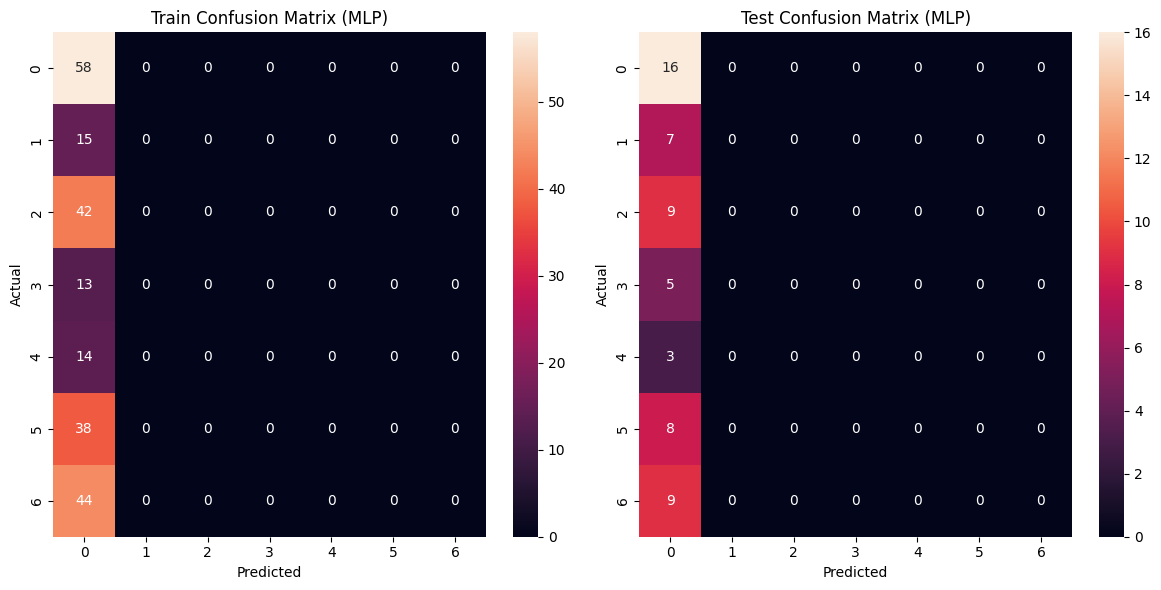

MLP (Train) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.26      1.00      0.41        58
 B-CELL_ALL_TCF3-PBX1       1.00      0.00      0.00        15
  B-CELL_ALL_HYPERDIP       1.00      0.00      0.00        42
      B-CELL_ALL_HYPO       1.00      0.00      0.00        13
       B-CELL_ALL_MLL       1.00      0.00      0.00        14
     B-CELL_ALL_T-ALL       1.00      0.00      0.00        38
B-CELL_ALL_ETV6-RUNX1       1.00      0.00      0.00        44

             accuracy                           0.26       224
            macro avg       0.89      0.14      0.06       224
         weighted avg       0.81      0.26      0.11       224

MLP (Test) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.28      1.00      0.44        16
 B-CELL_ALL_TCF3-PBX1       1.00      0.00      0.00         7
  B-CELL_ALL_HYPERDIP       1.00      0.00   

In [52]:
plot_confusion_matrix_and_report(
    MLP_train_confusion_matrix, MLP_train_classification_report,
    MLP_test_confusion_matrix, MLP_test_classification_report,
    "MLP"
)

In [53]:
(
    KNN_train_confusion_matrix,
    KNN_train_classification_report,
    KNN_test_confusion_matrix,
    KNN_test_classification_report,
) = train_and_evaluate_model(KNN, X_train, y_train, X_test, y_test)

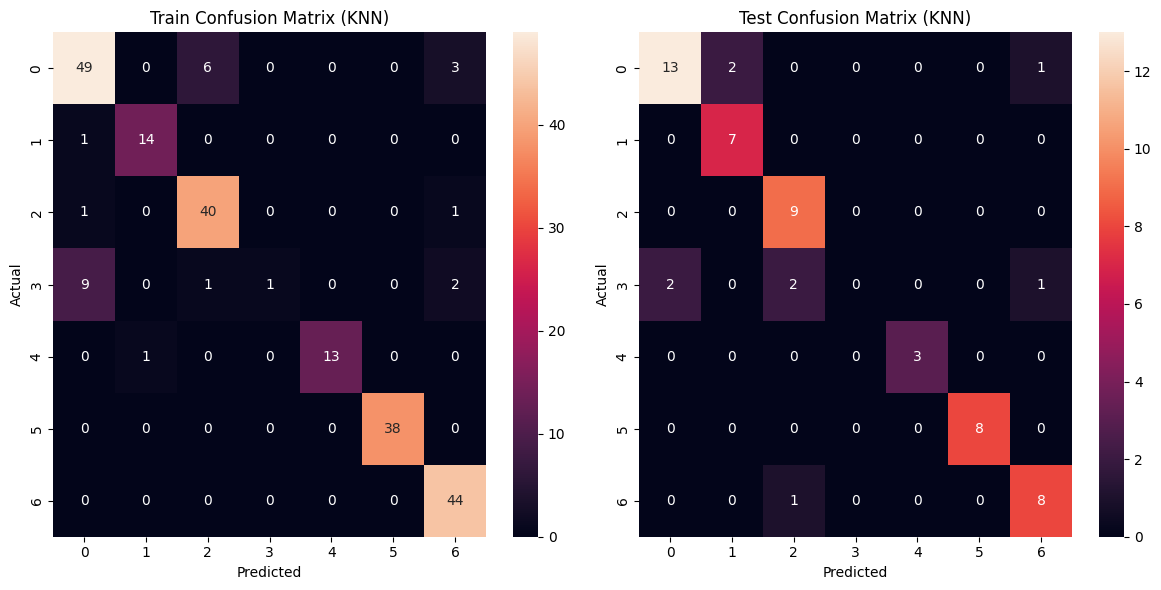

KNN (Train) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.82      0.84      0.83        58
 B-CELL_ALL_TCF3-PBX1       0.93      0.93      0.93        15
  B-CELL_ALL_HYPERDIP       0.85      0.95      0.90        42
      B-CELL_ALL_HYPO       1.00      0.08      0.14        13
       B-CELL_ALL_MLL       1.00      0.93      0.96        14
     B-CELL_ALL_T-ALL       1.00      1.00      1.00        38
B-CELL_ALL_ETV6-RUNX1       0.88      1.00      0.94        44

             accuracy                           0.89       224
            macro avg       0.93      0.82      0.81       224
         weighted avg       0.90      0.89      0.87       224

KNN (Test) Classification Report:
                       precision    recall  f1-score   support

           B-CELL_ALL       0.87      0.81      0.84        16
 B-CELL_ALL_TCF3-PBX1       0.78      1.00      0.88         7
  B-CELL_ALL_HYPERDIP       0.75      1.00   

In [54]:
plot_confusion_matrix_and_report(
    KNN_train_confusion_matrix, KNN_train_classification_report,
    KNN_test_confusion_matrix, KNN_test_classification_report,
    "KNN"
)

In [55]:
dill.dump_session(SESSION_FILE)
